# Train Forward Kinematics of 3DOF Planar Manipulator

In [1]:
%matplotlib inline

from numpy import sin, cos
from functools import reduce
import numpy as np
from sklearn import gaussian_process as gp
from time import time

## Robot Model
Implementing the forward kinematics of a planar robot with n degrees of freedom. 
The degrees of freedom are set by providing the link lengths list. E.g. doing this:
```python
r = Robot([1, 1, 0.5, 0.5])
```
creates a robot with 4 degrees of freedom.

In [2]:
class Robot(object):
    def __init__(self, link_lengths=[1, 1, 1]):
        self._link_lengths = link_lengths

    @staticmethod
    def __create_trafo(q, l):
        return np.array([[cos(q), -sin(q), l * cos(q)],
                         [sin(q), cos(q), l * sin(q)],
                         [0, 0, 1]])

    def forward_kinematics(self, joint_angles):
        trafos = [self.__create_trafo(q, l) for q, l in zip(joint_angles, self._link_lengths)]
        flange = reduce(lambda x, y: x.dot(y), trafos)
        return np.array([flange[0, 2], flange[1, 2], np.angle(np.exp(1j*(sum(joint_angles))))])

    def forward_kinematics_deg(self, joint_angles_deg):
        return self.forward_kinematics(np.deg2rad(joint_angles_deg))

### Testing the robot model

In [3]:
test_robot = Robot([1, 1, 1])
test_robot.forward_kinematics_deg([0, 90, 90])

array([0.        , 1.        , 3.14159265])

## Gaussian Process Regression for Learning Forward Kinematics

The following class implements the regression of the forward kinematics. The training involves the following steps:
1. Sampling the configuration space uniformly
2. Call the robot forwards kinematics function for each sample to obtain training data
3. Train the gaussian process model

In [8]:
class ForwardKinematicsRegression(object):
    def __init__(self, dim=3, resolution=360):
        self._dim = dim
        self._resolution = resolution

    def fit(self, robot):
        g = gp.GaussianProcessRegressor()

        q = np.array([np.linspace(0, 360, self._resolution)]).T
        for i in range(self._dim - 1):
            qnew = np.linspace(0, 360, self._resolution)
            tiled = np.tile(q, (len(qnew), 1))
            repeated = np.repeat(qnew, q.shape[0]).reshape((-1, 1))
            q = np.hstack([repeated, tiled])

        q = np.deg2rad(q)
        forward_kin = np.apply_along_axis(robot.forward_kinematics, 1, q)
        print(f"Generated training set of {q.shape[0]} samples.")
        print("Start training...")
        tic = time()
        g.fit(q, forward_kin)
        print(f"Finished training after {time() - tic:.3f}s.")
        return g

## Perform the training for different amount of samples

The model is trained for different resolutions of the uniform sampling of the configuration space in order to compare the results:

In [9]:
models = {
    'rough': ForwardKinematicsRegression(resolution=6).fit(test_robot),
    'medium': ForwardKinematicsRegression(resolution=12).fit(test_robot),
    'fine': ForwardKinematicsRegression(resolution=24).fit(test_robot)
}

Generated training set of 216 samples.
Start training...
Finished training after 0.003s.
Generated training set of 1728 samples.
Start training...
Finished training after 0.169s.
Generated training set of 13824 samples.
Start training...
Finished training after 39.607s.


# Evaluate the Trained Models
The forward kinematics predicted by the Gaussian Process regressor are compared to the ground truth forward kinematics computed using the implemented robot model.
Therefore, random point in configuration space are sampled and the difference of predicted vs. ground truth data is computed.

In [10]:
def evaluate_model(key, model, n_samples=10000):
    gpr = model

    def do_sample():
        q = np.random.uniform(0, 2*np.pi, 3) # Sample a point in configuration space uniformly
        predicted = model.predict(q.reshape(1, -1)) # Use the regressor to predict the forward kinematics
        fkin = test_robot.forward_kinematics(q) # Compute the forward kinematics using the robot model
        return (predicted - fkin).flatten()
    
    tic = time()
    e = np.array([do_sample() for _ in range(n_samples)])
    dt = 1e3*(time() - tic)/n_samples
    print(f"Inference in the {key} GPR model takes {dt:.3f}ms per sample.")
    return e
    

errors = {k: evaluate_model(k, model) for k, model in models.items()}

Inference in the rough GPR model takes 0.125ms per sample.
Inference in the medium GPR model takes 0.141ms per sample.
Inference in the fine GPR model takes 0.241ms per sample.


### First, compute statistical data of the errors

In [11]:
def print_statistics(e):
    for i, coor in zip([0, 1, 2], ['x', 'y', 'ϕ']):
        d = np.abs(e[:,i])
        print(f"{coor}-direction:\tmax: {np.max(d):.6f}\taverage: {np.average(d):.6f}\tstddev: {np.std(d):.6f}")
        
for key, e in errors.items():
    print(f"Statistics using the {key} Gaussian Process Regressor:")
    print_statistics(e)
    print()

Statistics using the rough Gaussian Process Regressor:
x-direction:	max: 0.476137	average: 0.057377	stddev: 0.060208
y-direction:	max: 0.404507	average: 0.061937	stddev: 0.061147
ϕ-direction:	max: 3.561959	average: 0.622755	stddev: 0.721065

Statistics using the medium Gaussian Process Regressor:
x-direction:	max: 0.013433	average: 0.001189	stddev: 0.001648
y-direction:	max: 0.016066	average: 0.001314	stddev: 0.001825
ϕ-direction:	max: 3.973117	average: 0.465237	stddev: 0.562915

Statistics using the fine Gaussian Process Regressor:
x-direction:	max: 0.000022	average: 0.000001	stddev: 0.000002
y-direction:	max: 0.000020	average: 0.000001	stddev: 0.000002
ϕ-direction:	max: 3.187522	average: 0.348944	stddev: 0.526684



## Second, plot histogram on the errors

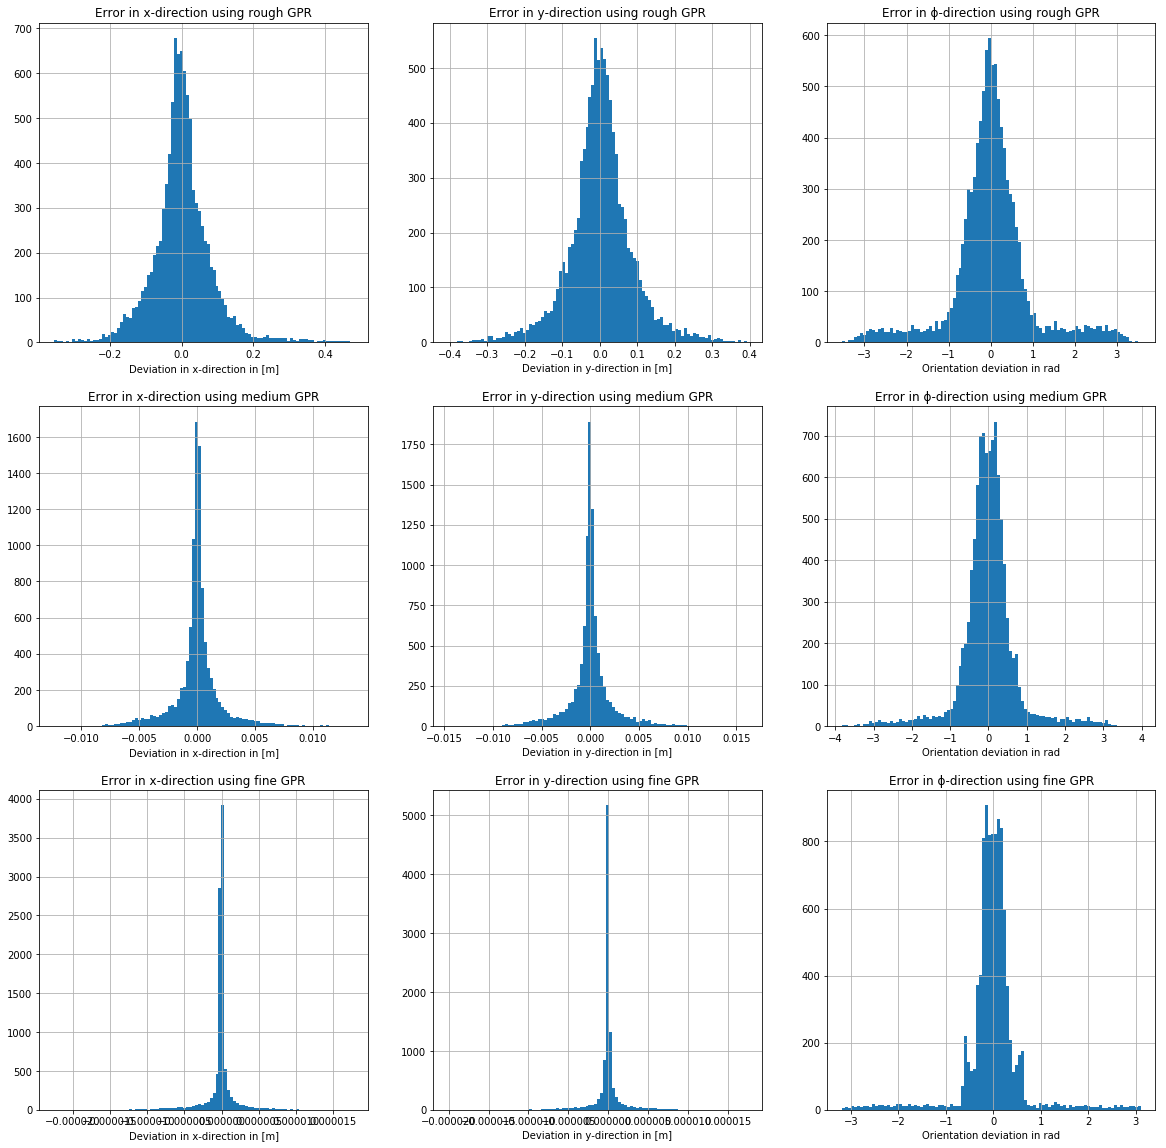

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(errors), 3, figsize=(20, 20))

for row, key in enumerate(errors.keys()):
    for index, coor in enumerate(['x', 'y', 'ϕ']):
        ax = axes[row, index]
        ax.hist(errors[key][:,index], bins=100)
        ax.set_title(f"Error in {coor}-direction using {key} GPR")
        ax.grid()
        if index in [0, 1]:
            ax.set_xlabel(f"Deviation in {coor}-direction in [m]")
        else:
            ax.set_xlabel(f"Orientation deviation in rad")

plt.show()

# Results of this vanilla approach

- I used the out-of-the-box Gaussian Process regressor, without any tuning of the kernel function
- *The prediction results are good for the tranlational components* (less than 10^-6 for the medium and fine GPR)
- The prediction results are bad for the rotational part given the representation used here

## Why is the orientation estimate bad

- Here, I use direct parametrization of the orientation in radians. There are discontinuities in the paramtrization
 - --> The performance is bad.
 
### How to make it better?
- Instead of using the raw angle in radians use sin and cos of the orientation in order to get a well-behaving function.
- In 3D use quaternions

# Training on well-behaved orientation of forward kinematics

Idea: The performance was bad in the orientation part. By making the function well-behaved using complex numbers, or quaternions in 3D, respectively it should be better to train on it.

In [15]:
class BetterForwardKinematicsRegression(object):
    def __init__(self, dim=3, resolution=360):
        self._dim = dim
        self._resolution = resolution

    def fit(self, robot):
        g = gp.GaussianProcessRegressor()

        q = np.array([np.linspace(0, 360, self._resolution)]).T
        for i in range(self._dim - 1):
            qnew = np.linspace(0, 360, self._resolution)
            tiled = np.tile(q, (len(qnew), 1))
            repeated = np.repeat(qnew, q.shape[0]).reshape((-1, 1))
            q = np.hstack([repeated, tiled])

        q = np.deg2rad(q)
        forward_kin = np.apply_along_axis(robot.forward_kinematics, 1, q)
        smooth_forward_kin = np.zeros((forward_kin.shape[0], 4))
        smooth_forward_kin[:,0:2] = forward_kin[:,0:2]
        smooth_forward_kin[:,2] = np.cos(forward_kin[:,2])
        smooth_forward_kin[:,3] = np.sin(forward_kin[:,2])
        print(f"Generated training set of {q.shape[0]} samples.")
        print("Start training...")
        tic = time()
        g.fit(q, smooth_forward_kin)
        print(f"Finished training after {time() - tic:.3f}s.")
        return g

In [16]:
better_models = {
    'rough': BetterForwardKinematicsRegression(resolution=6).fit(test_robot),
    'medium': BetterForwardKinematicsRegression(resolution=12).fit(test_robot),
    'fine': BetterForwardKinematicsRegression(resolution=24).fit(test_robot)
}

Generated training set of 216 samples.
Start training...
Finished training after 0.004s.
Generated training set of 1728 samples.
Start training...
Finished training after 0.176s.
Generated training set of 13824 samples.
Start training...
Finished training after 40.148s.


In [17]:
def evaluate_better_model(key, model, n_samples=10000):
    gpr = model

    def do_sample():
        q = np.random.uniform(0, 2*np.pi, 3) # Sample a point in configuration space uniformly
        raw = model.predict(q.reshape(1, -1)).flatten() # Use the regressor to predict the forward kinematics
        predicted = np.array([raw[0], raw[1], np.arctan2(raw[3], raw[2])]) # transform complex number back to angle
        fkin = test_robot.forward_kinematics(q) # Compute the forward kinematics using the robot model
        return (predicted - fkin).flatten()
    
    tic = time()
    e = np.array([do_sample() for _ in range(n_samples)])
    dt = 1e3*(time() - tic)/n_samples
    print(f"Inference in the better {key} GPR model takes {dt:.3f}ms per sample.")
    return e
    

errors_new = {k: evaluate_better_model(k, model) for k, model in better_models.items()}

Inference in the better rough GPR model takes 0.135ms per sample.
Inference in the better medium GPR model takes 0.155ms per sample.
Inference in the better fine GPR model takes 0.257ms per sample.


## Again, staticstical analysis of the errors
Now using the models trained on the smooth forward kinematics

In [18]:
for key, e in errors_new.items():
    print(f"Statistics using the {key} Gaussian Process Regressor on smooth forward kinematics:")
    print_statistics(e)
    print()

Statistics using the rough Gaussian Process Regressor on smooth forward kinematics:
x-direction:	max: 0.493520	average: 0.056145	stddev: 0.059473
y-direction:	max: 0.404671	average: 0.062367	stddev: 0.061830
ϕ-direction:	max: 6.280174	average: 0.093203	stddev: 0.538749

Statistics using the medium Gaussian Process Regressor on smooth forward kinematics:
x-direction:	max: 0.013489	average: 0.001173	stddev: 0.001662
y-direction:	max: 0.014637	average: 0.001289	stddev: 0.001775
ϕ-direction:	max: 0.007767	average: 0.001040	stddev: 0.001249

Statistics using the fine Gaussian Process Regressor on smooth forward kinematics:
x-direction:	max: 0.000024	average: 0.000001	stddev: 0.000002
y-direction:	max: 0.000028	average: 0.000001	stddev: 0.000002
ϕ-direction:	max: 0.000008	average: 0.000001	stddev: 0.000001



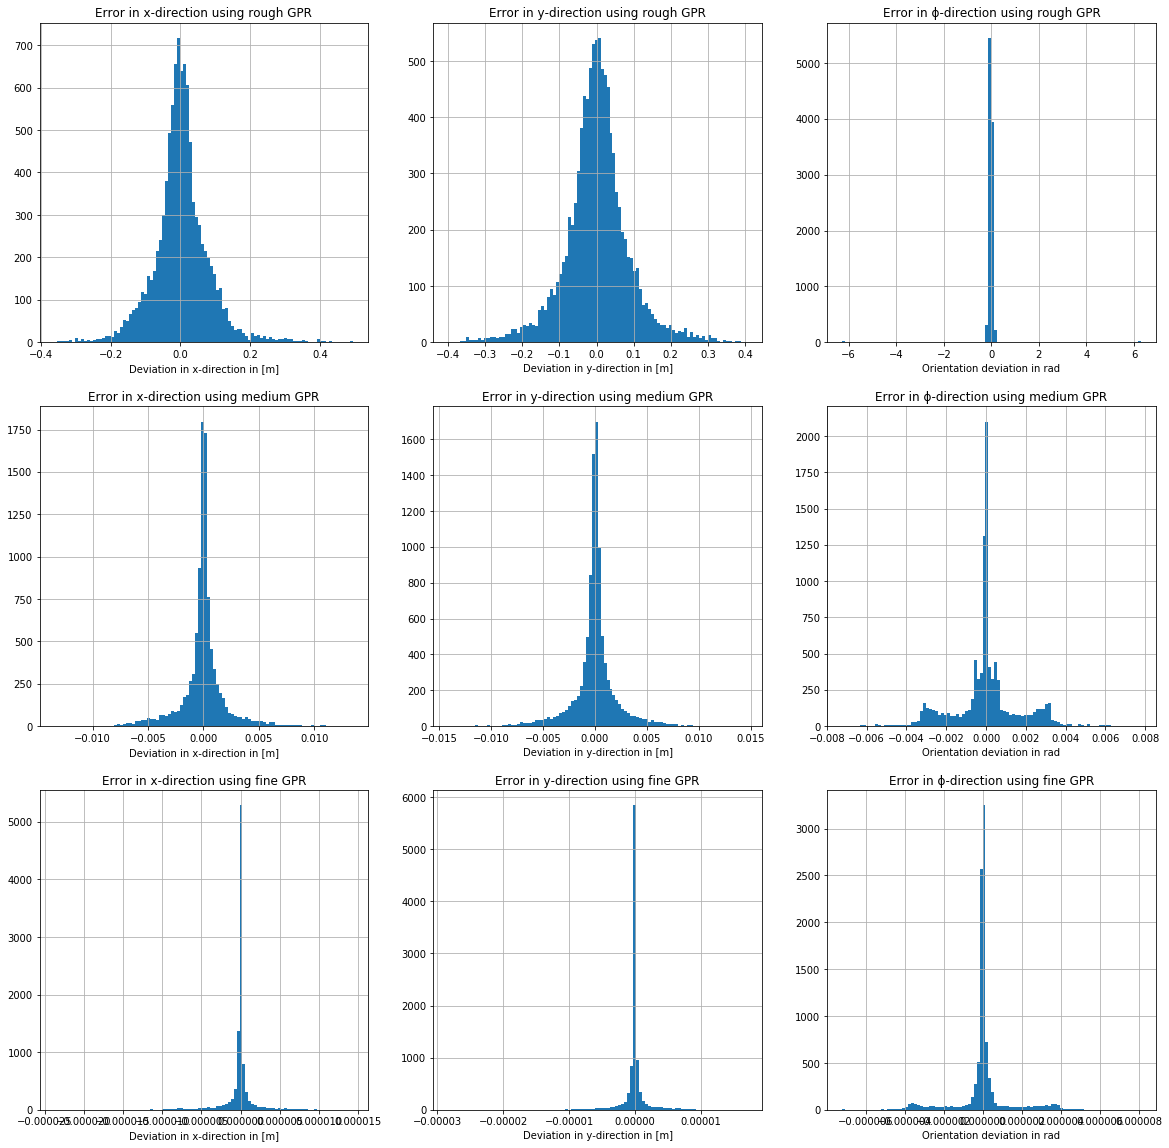

In [19]:
fig, axes = plt.subplots(len(errors_new), 3, figsize=(20, 20))

for row, key in enumerate(errors_new.keys()):
    for index, coor in enumerate(['x', 'y', 'ϕ']):
        ax = axes[row, index]
        ax.hist(errors_new[key][:,index], bins=100)
        ax.set_title(f"Error in {coor}-direction using {key} GPR")
        ax.grid()
        if index in [0, 1]:
            ax.set_xlabel(f"Deviation in {coor}-direction in [m]")
        else:
            ax.set_xlabel(f"Orientation deviation in rad")

plt.show()

# Results of the trained model on smooth forward kinematics

- I trained the gaussian process model on uniformly sampled configuration space
- For evalutation of the trained models, I use randomly sampled points in configuration space
- The prediction is now good for both tranlation and orientation
 - maximum error for x direction is < 1.4*10^-5m
 - maximum error for y direction is < 2.8*10^-5m
 - maximum error for ϕ is < 9*10^-6 rad

## Show the used kernel function

First, select the best model

In [20]:
m = better_models['fine']
m

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

## Kernel with optimized hyperparameters used in the Gaussian Process

In [29]:
m.kernel_

1**2 * RBF(length_scale=1)

# Marching Cubes to plot the manifold given as implicit function

Problem: We have a implicit function, which is not trivial to plot. For example let $x_0 = 1$, then we wanna plot $f(q)_x = x_0$.

Idea: Use **marching cubes** to plot the implicit function.